In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
import numpy as np
from epi.models import Parameter, Model
from epi.util import pairplot
import tensorflow as tf
from epi.SC_Circuit_4 import SC_acc, SC_acc_diff, SC_acc_var, SC_sim, SC_sim_opto, unwrap

import os
figdir = "../../written/SC_model/figs/"

c_LP = '#3B8023'
c_LA = '#EA8E4C'
c_RA = '#F4C673'
c_RP = '#81C176'


### 1. Define the V1Circuit model

In [2]:
lb = -5.
ub = 5.

sW = Parameter("sW", 1, lb=lb, ub=ub)
vW = Parameter("vW", 1, lb=lb, ub=ub)
dW = Parameter("dW", 1, lb=lb, ub=ub)
hW = Parameter("hW", 1, lb=lb, ub=ub)

parameters = [sW, vW, dW, hW]

model = Model("SC_Circuit_var", parameters)

In [3]:
model.set_eps(SC_acc_var)
mu_std = 0.05

epi_df = model.get_epi_df()
epi_df['c0'] = [al_hps['c0'] for al_hps in epi_df['AL_hps']]
epi_df['beta'] = [al_hps['beta'] for al_hps in epi_df['AL_hps']]
epi_df['random_seed'] = [al_hps['random_seed'] for al_hps in epi_df['arch']]
epi_df['bnmom'] = [al_hps['random_seed'] for al_hps in epi_df['arch']]
epi_df['p'] = [ep['mu'][0] for ep in epi_df['EP']]
epi_df['mu_std'] = [np.sqrt(ep['mu'][2]) for ep in epi_df['EP']]
epi_df['mu_len'] = [ep['mu'].shape[0] for ep in epi_df['EP']]

data/epi/SC_Circuit_var/a2c18082e7d1e33948198182605af211/D4_C3_L2_U50_bnmom=9.90E-01_PA_rs3/bf3b1cebb27a8fce517e4525f6a8a421/N100_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta2.00E+00
mu std 0.05
beta 2.0
random seed 3


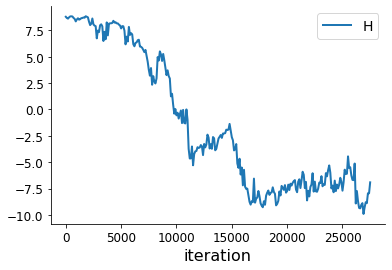

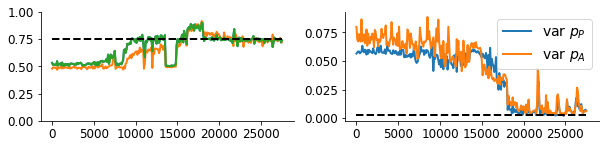

In [4]:
p = 0.75
mu =  np.array([p, 1-p, mu_std**2, mu_std**2])
epi_df2 = epi_df[(epi_df['p']==p) 
               & (epi_df['beta']==2.)
               & (epi_df['random_seed']==3) 
               & (epi_df['c0']==1e2) 
               & (epi_df['mu_std']==mu_std) 
               & (epi_df['mu_len'] == 4)]


paths = sorted(epi_df2['path'].unique())
for i, path in enumerate(paths):
    print(path)
    epi_df2 = epi_df[epi_df['path'] == path]
    print('mu std', epi_df2['mu_std'].iloc[0])
    print('beta', epi_df2['beta'].iloc[0])
    print('random seed', epi_df2['random_seed'].iloc[0])
    epi_df2.plot('iteration', 'H')
    plt.show()
    fig, axs = plt.subplots(1,2,figsize=(10,2))
    Rs = ['R%d' % r for r in range(1,3)]
    axs[0].plot(epi_df2['iteration'], epi_df2['R1'] + mu[0], label=r'$p_P$')
    axs[0].plot(epi_df2['iteration'], 1.-(epi_df2['R2'] + mu[1]), label=r'$p_A$')
    axs[0].plot(epi_df2['iteration'], epi_df2['R1'] + mu[0], label=r'$p_P$')
    axs[0].plot([0, epi_df2['iteration'].max()], [mu[0], mu[0]], 'k--')
    axs[0].set_ylim([0,1])
    axs[1].plot(epi_df2['iteration'], epi_df2['R3'], label=r'var $p_P$')
    axs[1].plot(epi_df2['iteration'], epi_df2['R4'], label=r'var $p_A$')
    axs[1].plot([epi_df2['iteration'].min(), epi_df2['iteration'].max()], [mu_std**2, mu_std**2], 'k--')
    plt.legend()
    plt.show()

In [5]:
for path in paths:
    print(path)

data/epi/SC_Circuit_var/a2c18082e7d1e33948198182605af211/D4_C3_L2_U50_bnmom=9.90E-01_PA_rs3/bf3b1cebb27a8fce517e4525f6a8a421/N100_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta2.00E+00


In [6]:
best_Hs = []
convergeds = []
best_ks = []
nu = 0.25
for i, path in enumerate(paths):
    _epi_df = epi_df[epi_df['path'] == path]
    df_row = _epi_df.iloc[0]
    init = df_row['init']
    init_params = {"mu":init["mu"], "Sigma":init["Sigma"]}
    nf = model._df_row_to_nf(df_row)
    aug_lag_hps = model._df_row_to_al_hps(df_row)
    best_k, converged, best_H = model.get_convergence_epoch(init_params, nf, mu, aug_lag_hps, 
                                    alpha=0.05, nu=nu)
    best_Hs.append(best_H)
    convergeds.append(converged)
    best_ks.append(best_k)


bestHs = np.array(best_Hs)
best_ks = np.array(best_ks)

best_Hs = np.array([x if x is not None else np.nan for x in best_Hs])
ind = np.nanargmax(best_Hs)

path = paths[ind]
best_k = int(best_ks[ind])
best_H = best_Hs[ind]

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
12: 0.69_0.95_0.01_0.00


ValueError: All-NaN slice encountered

In [7]:
print('ind', ind, 'best_k', best_k)

NameError: name 'ind' is not defined

In [5]:
path = paths[0]
best_k = 10

In [6]:
_epi_df = epi_df[epi_df['path'] == path]
df_row = _epi_df.iloc[0]
init = df_row['init']
init_params = {"mu":init["mu"], "Sigma":init["Sigma"]}
nf = model._df_row_to_nf(df_row)
aug_lag_hps = model._df_row_to_al_hps(df_row)

dist = model._get_epi_dist(best_k, init_params, nf, mu, aug_lag_hps)
print('dist', dist)

dist <epi.models.Distribution object at 0x7fce38fe8dd8>


In [7]:
print(path, best_k)

data/epi/SC_Circuit_var/a2c18082e7d1e33948198182605af211/D4_C3_L2_U50_bnmom=9.90E-01_PA_rs3/bf3b1cebb27a8fce517e4525f6a8a421/N100_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta2.00E+00 10


Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
tf.Tensor(
[[-0.6804069  -2.8917763  -1.8481414  -1.2650414 ]
 [ 2.0421603   4.6242695  -0.3462145   2.1290638 ]
 [-0.8015871  -3.4824493  -2.1155097  -1.3530767 ]
 ...
 [-0.93760824 -3.4059868  -2.3438559  -1.4564006 ]
 [-0.8991503  -3.772055   -2.2919827  -1.4347632 ]
 [-0.69441676 -2.8223815  -2.0319476  -1.2385596 ]], shape=(1000, 4), dtype=float32)


(0.4, 1.0)

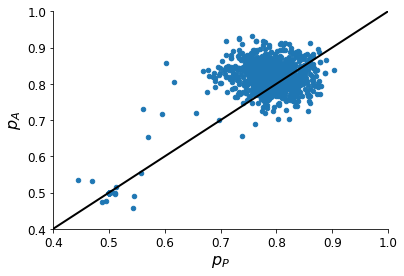

In [8]:
z, log_q_z = dist.nf(1000)
print(z)
z = z.numpy()
log_q_z = log_q_z.numpy()
"""M = 500
z = np.zeros((M, model.D), dtype=np.float32)
for j in range(model.D):
    z[:,j] = np.random.uniform(model.parameters[j].lb, model.parameters[j].ub, (M,))"""
T_x = model.eps(z).numpy()
plt.scatter(T_x[:,0], 1-T_x[:,1], s=20)
plt.plot([0,1], [0,1], 'k-')
plt.xlabel(r'$p_P$')
plt.ylabel(r'$p_A$')
plt.xlim([0.4, 1.])
plt.ylim([0.4, 1.])

In [9]:
p_stars = [0.65, 0.85]
z_stars = []
for p_star in p_stars:
    mu_star = np.array([p_star, 1.-p_star])[None,:]
    d = np.linalg.norm(T_x[:,:2]-mu_star, axis=1)
    min_ind = np.argmin(d)
    z_stars.append(z[min_ind,:])
    
z_stars = np.array(z_stars)
alpha_c_star = 1.
c_stars = [np.concatenate((np.array([0,0,0]), np.array([alpha_c_star]))),
             np.concatenate((.7*np.ones((3,)), np.array([alpha_c_star])))]

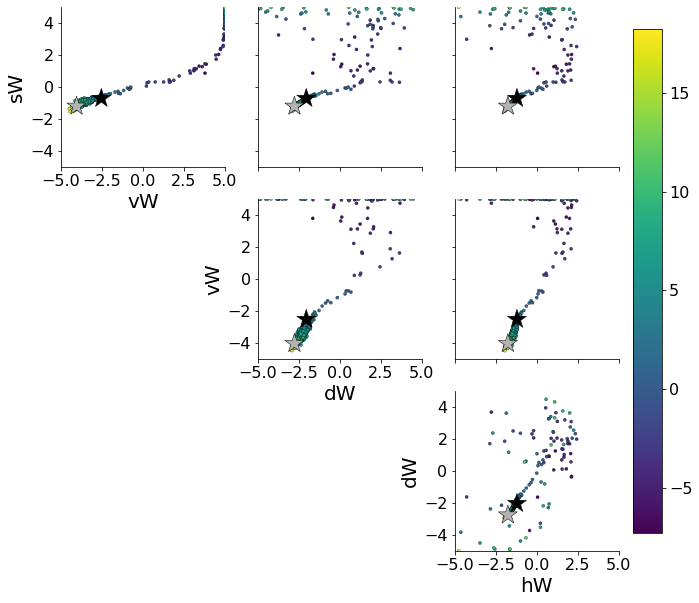

In [13]:
_lb = np.array([p.lb[0] for p in model.parameters])
_ub = np.array([p.ub[0] for p in model.parameters])
z_labels = [p.name for p in model.parameters]
fig = pairplot(z, np.arange(4), z_labels, starred=z_stars, c_starred=c_stars,
               fontsize=20, figsize=(10,10),
               lb=_lb, ub=_ub, c=log_q_z)

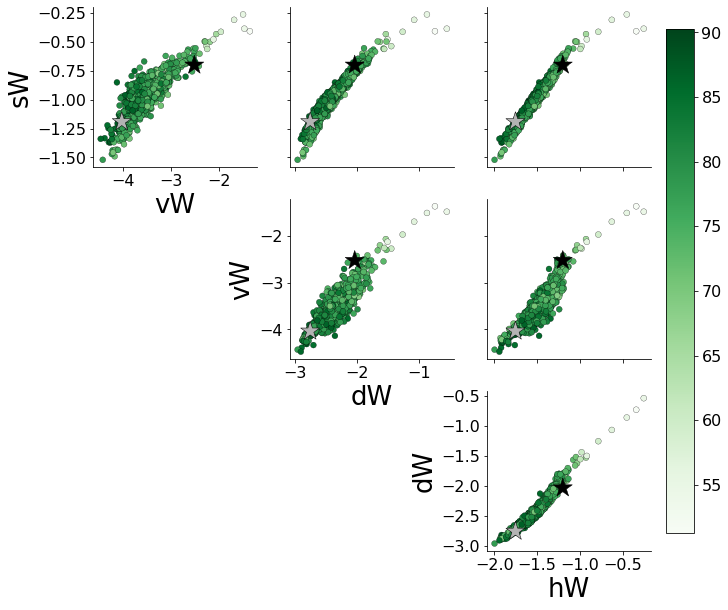

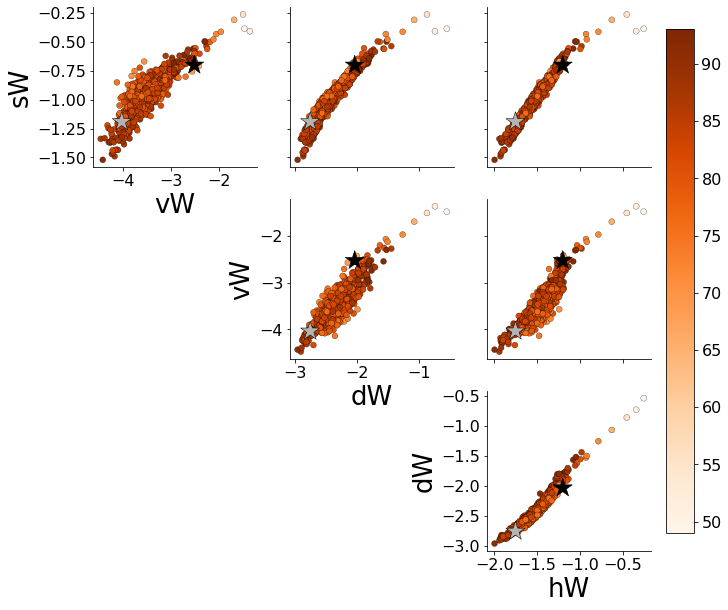

In [10]:
cmap_g = plt.get_cmap('Greens')
cmap_o = plt.get_cmap('Oranges')

_lb = np.array([p.lb[0] for p in model.parameters])
_ub = np.array([p.ub[0] for p in model.parameters])
z_labels = [p.name for p in model.parameters]
plot_inds = np.logical_and(
    np.logical_and(z[:,0] < 0., z[:,1] < 0.), 
    np.logical_and(z[:,2] < 0., z[:,3] < 0.))
plot_inds = np.logical_and(plot_inds, z[:,3]  > -2.)
z_plot = z[plot_inds]
#log_q_z_plot = dist.log_prob(z_plot)
log_q_z_plot = log_q_z[plot_inds]
T_x_plot = T_x[plot_inds]
fig = pairplot(z_plot, np.arange(4), z_labels, starred=z_stars, c_starred=c_stars, 
               fontsize=26, figsize=(10,10), ticksize=16, cmap=cmap_g, s=35,
               c=100*T_x_plot[:,0])
plt.savefig(os.path.join(figdir, "SC_EPI_pP.pdf"))

fig = pairplot(z_plot, np.arange(4), z_labels, starred=z_stars, c_starred=c_stars, 
               fontsize=26, figsize=(10,10), ticksize=16, cmap=cmap_o, s=35,
               c=100*(1.-T_x_plot[:,1]))
plt.savefig(os.path.join(figdir, "SC_EPI_pA.pdf"))

(1000, 4)
73.5, 74.0


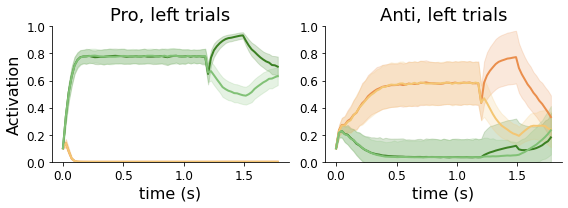

87.3, 80.5


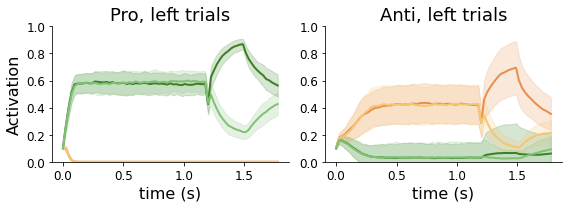

In [12]:
print(z.shape)
u_t, v_t = SC_sim(*unwrap(z_stars))
T_x_stars = model.eps(z_stars)

t_cue_delay = 1.2
t_choice = 0.3
t_post_choice = 0.3
t_total = t_cue_delay + t_choice + t_post_choice
dt = 0.024
t = np.arange(0.0, t_total, dt)
T = t.shape[0]

neuron_labels = ['LP', 'LA', 'RA', 'RP']
colors = [c_LP, c_LA, c_RA, c_RP]
C_titles = ['Pro, left trials', 'Anti, left trials']
for m in range(len(z_stars)):
    print("%.1f, %.1f" % (100*T_x_stars[m,0], 100-100*T_x_stars[m,1]))
    fig, axs = plt.subplots(1,2,figsize=(8, 3))
    for c in range(2):
        for i in range(4):
            mean_v = np.mean(v_t[:,m,c,i,:], axis=1)
            std_v = np.std(v_t[:,m,c,i,:], axis=1)
            axs[c].fill_between(t, mean_v - std_v, mean_v + std_v, color=colors[i], alpha=0.2)
            axs[c].plot(t, mean_v, label=neuron_labels[i], c=colors[i])
            axs[c].set_title(C_titles[c])
            axs[c].set_ylim([0,1])
        axs[c].set_xlabel('time (s)')
    axs[0].set_ylabel('Activation')
        
    plt.tight_layout()
    plt.savefig(os.path.join(figdir, "sim%d.pdf" % (m+1)))
    plt.show()

In [ ]:
"""def plot_p_corrs(x, xlabel, pP, pA):
    fig, ax = plt.subplots(1,1,figsize=(5,4))
    x = np.concatenate((x,x), axis=0)
    p = np.concatenate((pP, pA), axis=0)
    c = len(pP)*[c_LP] + len(pA)*[c_RP]
    N = len(c)
    randperm = list(np.random.permutation(N).astype(np.int32))
    x = [x[i] for i in randperm]
    p = [p[i] for i in randperm]
    c = [c[i] for i in randperm]
    ax.scatter(x, p, s=20, c=c, alpha=0.5)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(r'$p$')
    plt.show()"""

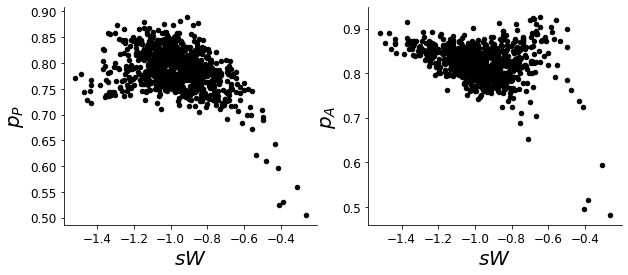

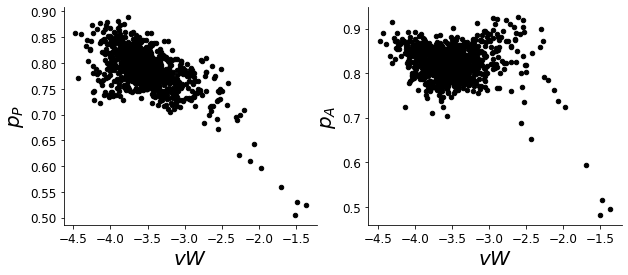

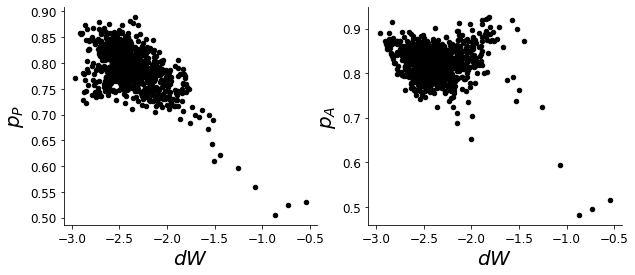

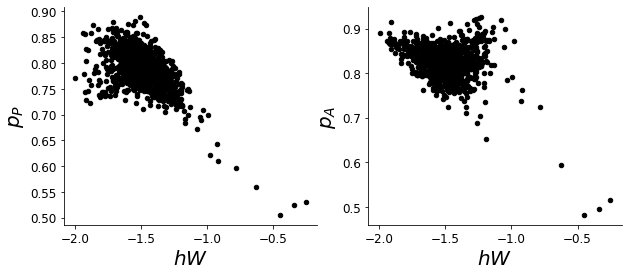

In [13]:
T_x_plot = SC_acc(*unwrap(z_plot))

sW = z_plot[:,0]
vW = z_plot[:,1]
dW = z_plot[:,2]
hW = z_plot[:,3]
pP = T_x_plot[:,0]
pA = 1. - T_x_plot[:,1]

def plot_p_corrs(x, xlabel, pP, pA, c=None, fontsize=None):
    if c is None:
        c = 'k'
    if fontsize is None:
        fontsize = 20
    fig, axs = plt.subplots(1,2,figsize=(10,4))
    axs[0].scatter(x, pP, s=20, c=c)
    axs[0].set_xlabel(xlabel, fontsize=fontsize)
    axs[0].set_ylabel(r'$p_P$', fontsize=fontsize)
    axs[1].scatter(x, pA, s=20, c=c)
    axs[1].set_xlabel(xlabel, fontsize=fontsize)
    axs[1].set_ylabel(r'$p_A$', fontsize=fontsize)
    
    
plot_p_corrs(sW, r'$sW$', pP, pA)
plot_p_corrs(vW, r'$vW$', pP, pA)
plot_p_corrs(dW, r'$dW$', pP, pA)
plot_p_corrs(hW, r'$hW$', pP, pA)

In [14]:
Wrow1 = tf.stack([sW, vW, dW, hW], axis=1)
Wrow2 = tf.stack([vW, sW, hW, dW], axis=1)
Wrow3 = tf.stack([dW, hW, sW, vW], axis=1)
Wrow4 = tf.stack([hW, dW, vW, sW], axis=1)

W = tf.stack([Wrow1, Wrow2, Wrow3, Wrow4], axis=1)

def get_schur_eigs(W):
    # returns 
    T, Z = scipy.linalg.schur(W)
    b = Z.copy()
    b[b<0.0] = -1
    b[b>0.0] = 1
    modes = 0.25*np.array([[1.0, 1.0, 1.0, 1.0],   # all mode
                          [-1.0, -1.0, 1.0, 1.0], # side mode
                          [1.0, -1.0, -1.0, 1.0], # task mode
                          [-1.0, 1.0, -1.0, 1.0]]) # diag mode
    X = np.abs(np.dot(modes,b))  # (template_mode x z_col)
    eigs = np.zeros((4,))
    for i in range(4):
        z_ind = np.argmax(X[i] == 1.0)
        eigs[i] = T[z_ind, z_ind]
    return eigs

eigs = np.array([get_schur_eigs(W[i]) for i in range(sW.shape[0])])

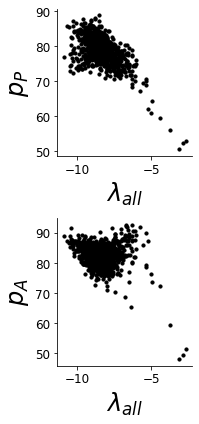

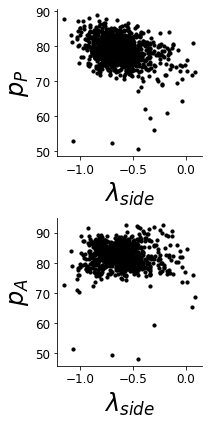

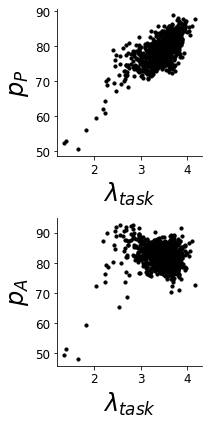

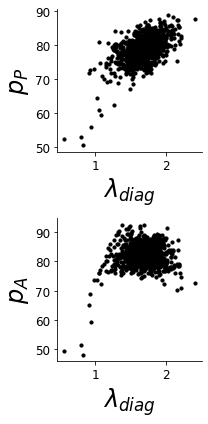

In [15]:
def plot_p_corrs(x, xlabel, pP, pA, c=None, fontsize=None):
    if c is None:
        c = 'k'
    if fontsize is None:
        fontsize = 20
    fig, axs = plt.subplots(2,1,figsize=(3,6))
    axs[0].scatter(x, 100*pP, s=10, c=c)
    axs[0].set_xlabel(xlabel, fontsize=fontsize)
    axs[0].set_ylabel(r'$p_P$', fontsize=fontsize)
    axs[1].scatter(x, 100*pA, s=10, c=c)
    axs[1].set_xlabel(xlabel, fontsize=fontsize)
    axs[1].set_ylabel(r'$p_A$', fontsize=fontsize)
    
eig_names = ['all', 'side', 'task', 'diag']
for i, eig_name in enumerate(eig_names):
    plot_p_corrs(eigs[:,i], r'$\lambda_{%s}$' % eig_name, pP, pA, fontsize=24)
    plt.tight_layout()
    plt.savefig(os.path.join(figdir, "lambda_%s.pdf" % eig_name))


(1000, 4)
69.3, 77.0


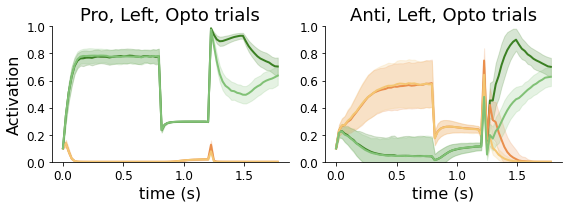

82.2, 81.6


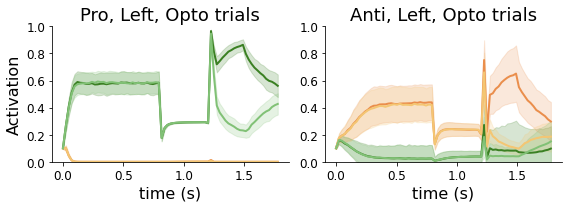

In [17]:
print(z.shape)
u_t, v_t = SC_sim_opto(*unwrap(z_stars))
T_x_stars = model.eps(z_stars)

t_cue_delay = 1.2
t_choice = 0.3
t_post_choice = 0.3
t_total = t_cue_delay + t_choice + t_post_choice
dt = 0.024
t = np.arange(0.0, t_total, dt)
T = t.shape[0]

neuron_labels = ['LP', 'LA', 'RA', 'RP']
colors = [c_LP, c_LA, c_RA, c_RP]
C_titles = ['Pro, Left trials', 'Anti, Left trials',
            'Pro, Left, Opto trials', 'Anti, Left, Opto trials']
for m in range(len(z_stars)):
    print("%.1f, %.1f" % (100*T_x_stars[m,0], 100-100*T_x_stars[m,1]))
    fig, axs = plt.subplots(1,2,figsize=(8, 3))
    for c in range(2,4):
        for i in range(4):
            mean_v = np.mean(v_t[:,m,c,i,:], axis=1)
            std_v = np.std(v_t[:,m,c,i,:], axis=1)
            axs[c-2].fill_between(t, mean_v - std_v, mean_v + std_v, color=colors[i], alpha=0.2)
            axs[c-2].plot(t, mean_v, label=neuron_labels[i], c=colors[i])
            axs[c-2].set_title(C_titles[c])
            axs[c-2].set_ylim([0,1])
        axs[c-2].set_xlabel('time (s)')
    axs[0].set_ylabel('Activation')
        
    plt.tight_layout()
    plt.savefig(os.path.join(figdir, "opto_sim%d.pdf" % (m+1)))
    plt.show()

In [18]:
T_x2 = SC_acc_diff(*unwrap(z_plot))
print(T_x2.shape)

(910, 2)


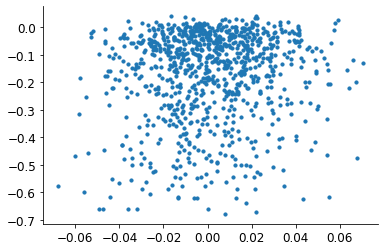

In [26]:
plt.scatter(T_x2[:,0], T_x2[:,1], s=10)

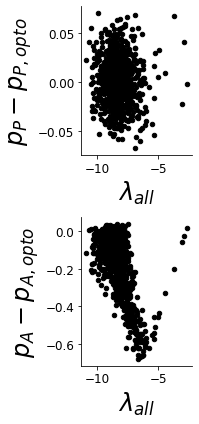

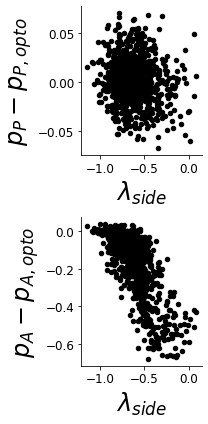

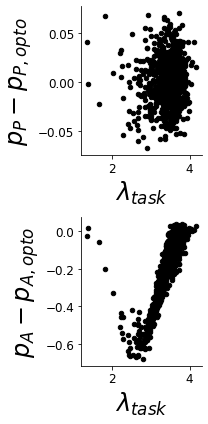

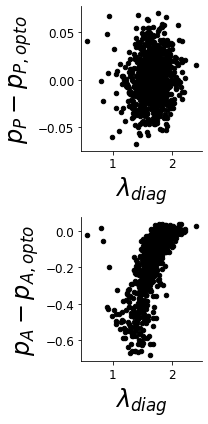

In [25]:
def plot_diff_corrs(x, xlabel, diff1, diff2, c=None, fontsize=None):
    if c is None:
        c = 'k'
    if fontsize is None:
        fontsize = 20
    fig, axs = plt.subplots(2,1,figsize=(3,6))
    axs[0].scatter(x, diff1, s=20, c=c)
    axs[0].set_xlabel(xlabel, fontsize=fontsize)
    axs[0].set_ylabel(r'$p_P-p_{P,opto}$', fontsize=fontsize)
    axs[1].scatter(x, diff2, s=20, c=c)
    axs[1].set_xlabel(xlabel, fontsize=fontsize)
    axs[1].set_ylabel(r'$p_A-p_{A,opto}$', fontsize=fontsize)
    
for i, eig_name in enumerate(eig_names):
    plot_diff_corrs(eigs[:,i], r'$\lambda_{%s}$' % eig_name, T_x2[:,0], T_x2[:,1], fontsize=24)
    plt.tight_layout()
    plt.savefig(os.path.join(figdir, "lambda_opto_%s.pdf" % eig_name))
